In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
dest = '/content/drive/MyDrive/HSE Final Project/to_train'
name = 'submit_8_abandoned.csv'

df = pd.read_csv(dest + '/' + name)
df.head()

,shop_id,item_id,month,year,date_block_num,item_cnt,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt
0,0,19,1,2013,0,0,28.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02222,0.0,0.02222
1,0,27,1,2013,0,0,2499.0,0,0,0.0,0.0,29,4,19,False,5,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.15550,0.0,0.05682
2,0,28,1,2013,0,0,549.0,0,0,0.0,0.0,29,4,30,False,5,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.17770,0.0,0.14120
3,0,29,1,2013,0,0,2499.0,0,0,0.0,0.0,29,4,23,False,5,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08887,0.0,0.03738
4,0,32,1,2013,0,6,349.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.64500,8.0,1.31900


In [ ]:
df['shop_id'] = df['shop_id'].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)
df['month'] = df['month'].astype(np.int8)
df['year'] = df['year'].astype(np.int16)
df['date_block_num'] = df['date_block_num'].astype(np.int8)
df['item_cnt'] = df['item_cnt'].astype(np.int32)
df['prev_value'] = df['prev_value'].astype(np.int32)
df['prev_value_year'] = df['prev_value_year'].astype(np.int32)
df['shop_city'] = df['shop_city'].astype(np.int8)
df['shop_category'] = df['shop_category'].astype(np.int8)
df['item_category_id'] = df['item_category_id'].astype(np.int8)
df['digital'] = df['digital'].astype(np.bool_)
df['category_type'] = df['category_type'].astype(np.int8)
df['category_subtype'] = df['category_subtype'].astype(np.int8)
df['item_cnt_lag_2'] = df['item_cnt_lag_2'].astype(np.int32)
df['item_cnt_lag_3'] = df['item_cnt_lag_3'].astype(np.int32)
df['item_cnt_lag_4'] = df['item_cnt_lag_4'].astype(np.int32)
df['item_cnt_lag_5'] = df['item_cnt_lag_5'].astype(np.int32)
df['item_cnt_lag_6'] = df['item_cnt_lag_6'].astype(np.int32)

In [ ]:
for col in df.columns[22:40]:
    df[col] = df[col].astype(np.int32)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913804 entries, 0 to 10913803
Data columns (total 43 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    int8   
 1   item_id                    int16  
 2   month                      int8   
 3   year                       int16  
 4   date_block_num             int8   
 5   item_cnt                   int32  
 6   item_price                 float64
 7   prev_value                 int32  
 8   prev_value_year            int32  
 9   stock_prev                 float64
 10  stock_prev_year            float64
 11  shop_city                  int8   
 12  shop_category              int8   
 13  item_category_id           int8   
 14  digital                    bool   
 15  category_type              int8   
 16  category_subtype           int8   
 17  item_cnt_lag_2             int32  
 18  item_cnt_lag_3             int32  
 19  item_cnt_lag_4             int32  
 20  

Due to the fact that we predict future, it makes no sense to shuffle the data

In [ ]:
X_train = df[df.date_block_num < 33].drop(['item_cnt'], axis=1)
y_train = df[df.date_block_num < 33]['item_cnt']
X_valid = df[df.date_block_num == 33].drop(['item_cnt'], axis=1)
y_valid = df[df.date_block_num == 33]['item_cnt']

In [ ]:
learning_rate = 0.1
max_depth = 8
n_estimators = 1000
random_state = 13
verbosity = 2
obj = 'reg:squarederror'

In [ ]:
xgbr = xgb.XGBRegressor(verbosity=verbosity,
                        eta=learning_rate,
                        objective=obj,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        random_state=random_state)

In [ ]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [ ]:
xgbr.fit(X_train, y_train,
         eval_metric=['rmse', 'rmse'], eval_set=eval_set,
         early_stopping_rounds=15, verbose=True)

[01:37:54] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[01:39:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-rmse:3.02058	validation_1-rmse:4.10402
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 15 rounds.
[01:41:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-rmse:2.81244	validation_1-rmse:3.9949
[01:43:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-rmse:2.63149	validation_1-rmse:3.90555
[01:45:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

XGBRegressor(eta=0.1, max_depth=8, n_estimators=1000,
             objective='reg:squarederror', random_state=13, verbosity=2)

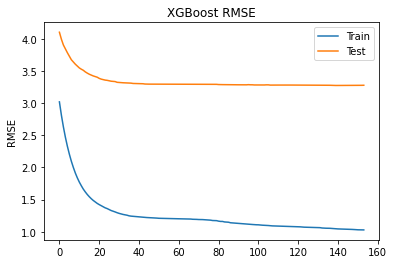

In [ ]:
import matplotlib.pyplot as plt

# retrieve performance metrics
results = xgbr.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot rmse
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [ ]:
import pickle

dest = '/content/drive/MyDrive/HSE Final Project/Models/'
file_name = 'xgb_reg_4.pkl'

# save
pickle.dump(xgbr, open(dest + file_name, 'wb'))

In [ ]:
import pickle

dest = '/content/drive/MyDrive/HSE Final Project/Models/'
file_name = 'xgb_reg_4.pkl'
# load
xgbr = pickle.load(open(dest + file_name, "rb"))

[15:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = xgbr.predict(X_valid)
y_pred_rounded = np.around(y_pred)
mse = mean_squared_error(y_valid, y_pred)
mse_rd = mean_squared_error(y_valid, y_pred_rounded)

print('MSE: %.2f' % mse)
print('RMSE: %.2f' % (mse ** (0.5)))

print('MSE (rounded): %.2f' % mse_rd)
print('RMSE (rounded): %.2f' % (mse_rd ** (0.5)))

MSE: 10.73
RMSE: 3.28
MSE (rounded): 10.76
RMSE (rounded): 3.28


In [ ]:
# from sklearn.metrics import mean_squared_log_error
# msle = mean_squared_log_error(y_test, y_pred)
# print('RMSLE: %.2f' % (msle ** (0.5)))

In [ ]:
dest = '/content/drive/MyDrive/HSE Final Project/to_test'
name = 'submit_8_test.csv'

test_df = pd.read_csv(dest + '/' + name)
test_df.head()

,shop_id,item_id,year,month,date_block_num,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt
0,5,5037,2015,11,34,2599.0,0,1,0.0,2599.0,3,3,19,False,5,9,1,3,1,1,1,1052,1092,1294,991,954,1445,25,110,119,54,105,65,21346,24604,23616,19872,22261,49726,0.0,0.9287,1.951
1,5,5320,2015,11,34,0.0,0,0,0.0,0.0,3,3,55,False,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.000
2,5,5233,2015,11,34,1199.0,1,0,1199.0,0.0,3,3,19,False,5,9,3,1,0,2,3,1052,1092,1294,991,954,0,42,80,150,37,119,0,21346,24604,23616,19872,22261,0,0.0,1.4290,1.657
3,5,5232,2015,11,34,1199.0,0,0,0.0,0.0,3,3,23,False,5,18,0,1,0,0,0,1052,1092,1294,0,0,0,28,48,65,0,0,0,21346,24604,23616,0,0,0,0.0,0.3333,1.093
4,5,5268,2015,11,34,0.0,0,0,0.0,0.0,3,3,20,False,5,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.000


In [ ]:
test_pred = xgbr.predict(test_df)
print(test_pred)

[-0.05080086 -0.00101537  0.06272843 ...  0.03488615 -0.00303149
  0.03116059]


In [ ]:
name_sample = 'sample_submission.csv'

sample = pd.read_csv(dest + '/' + name_sample)
sample.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [ ]:
sample.item_cnt_month = np.around(test_pred)
sample.head()

,ID,item_cnt_month
0,0,-0.0
1,1,-0.0
2,2,0.0
3,3,-0.0
4,4,-0.0


In [ ]:
dest = '/content/drive/MyDrive/HSE Final Project/submissions/'
sample.to_csv(dest + 'submission #16 (more lags).csv', index=False)

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

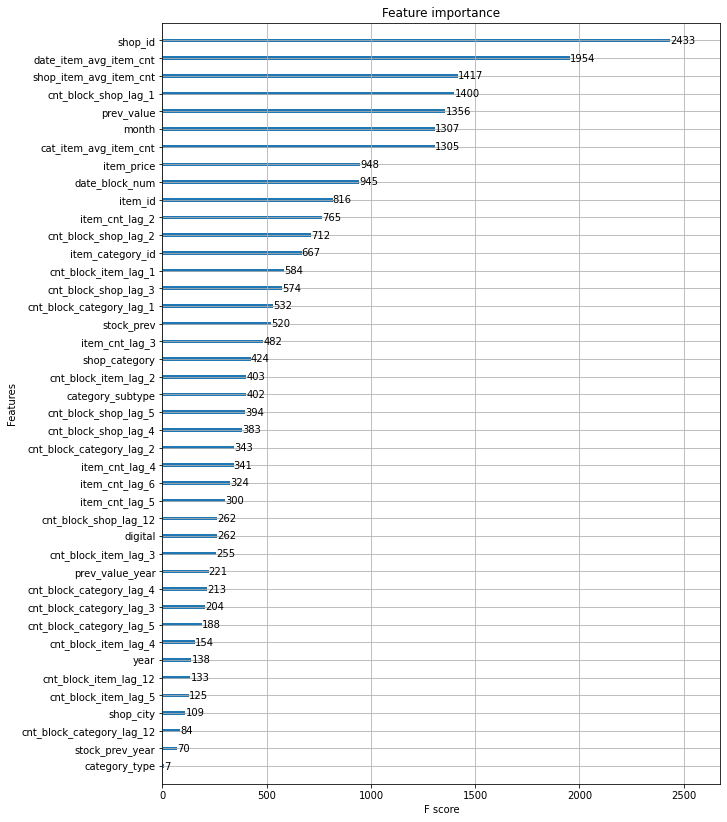

In [ ]:
plot_features(xgbr, (10, 14))